In [1]:
!pip install -U opencv-contrib-python==3.4.2.16

Requirement already up-to-date: opencv-contrib-python==3.4.2.16 in c:\users\emili\anaconda3\lib\site-packages (3.4.2.16)


In [1]:
import cv2
import numpy as np
import os

# Libraries for the autoencoder creation and usage of datasets classes to speed up learning

import matplotlib.pyplot as plt # plotting library
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn

In [53]:
## Extraction of the data 

In [2]:
# Path is the path from our current position to the folder that contains the images
# the path needs to end with a /
def get_names_images( path ) :
    # Getting the names of the images in the folder
    imgs_names = [filename for filename in os.listdir(path)]
    imgs_names.pop()
    imgs = [ cv2.imread(path+name, 0) for name in imgs_names]
    return imgs_names, imgs

In [3]:
def feature_extraction4dataset(detector, imgs) :
    # Extracting the keypoints for the dataset
    key_points = []
    descriptors = []
    for img in imgs :
        kp, des = detector.detectAndCompute(img,None)
        # We need them to be in the same vector
        for idx in range(len(kp)) :
            key_points.append(kp[idx])
            descriptors.append(des[idx])
    return key_points, descriptors

In [56]:
# Saving the list of the images paths
folder_train = 'portelloDataset/'
imgs_train_name, imgs_train = get_names_images(folder_train)

# Saving the list of the images paths for validation
folder_val = 'castle-P19/images/'
imgs_val_name, imgs_val = get_names_images(folder_val)

# Saving the list of the images paths for testing
folder_test = 'tisoDataset/'
imgs_test_name, imgs_test = get_names_images(folder_test)

In [55]:
# Setting the threshold for the feature detector 
minHessian = 400
detector = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)

# set to the extended version of surf
detector.setExtended(True)

In [6]:
# Extracting the keypoints of the train_dataset
key_points_train, descriptors_train = feature_extraction4dataset(detector, imgs_train)

In [7]:
# Extracting the keypoints of the validation_dataset
key_points_val, descriptors_val = feature_extraction4dataset(detector, imgs_val)

In [8]:
# Extracting the keypoints of the test_dataset
key_points_test, descriptors_test = feature_extraction4dataset(detector, imgs_test)

In [57]:
class KpDataset(Dataset):

  def __init__(self, train_set, transform=None):
    self.transform = transform

    # Get x and y values from each tuple and append to self.data
    self.data = train_set
    
    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    # The length of the dataset is simply the length of the self.data list
    return len(self.data)

  def __getitem__(self, idx):
    # Our sample is the element idx of the list self.data
    sample = self.data[idx]
    if self.transform:
        sample = self.transform(sample)
    return sample

In [58]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        return torch.tensor(sample)

In [59]:
# Transform to tensor
train_transform = transforms.Compose([ToTensor()])

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [60]:
# Training set 
train_dataset = KpDataset(descriptors_train, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=300, shuffle=True, num_workers=0)

# Validation set 
val_dataset = KpDataset(descriptors_val, transform=train_transform)
val_dataloader = DataLoader(val_dataset, batch_size=300, shuffle=False, num_workers=0)

# Test set 
test_dataset = KpDataset(descriptors_test, transform=train_transform)
test_dataloader = DataLoader(test_dataset, batch_size=300, shuffle=False, num_workers=0)

In [61]:
class VarEncoder(nn.Module):
    
    def __init__(self, input_dim, encoded_space_dim):
        super().__init__()
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First Layer
            nn.Linear(input_dim, 100),
            nn.ReLU(True),
            
            # Second Layer
            nn.Linear(100, 80),
            nn.ReLU(True),
            
            # Third Layer
            nn.Linear(80, 60),
        )

        self.mu_out = nn.Linear(60, encoded_space_dim)
        self.std_out = nn.Linear(60, encoded_space_dim) 
        
    def forward(self, x):
        # # Apply linear layers
        x = self.encoder_lin(x)

        # Apply last layers to obtain mu and var
        mu = self.mu_out(x)
        std = self.std_out(x)
        weight = torch.normal(mean=0.0, std=1.0, size=(1, 1)).to(device)
        return weight * std + mu, mu, std 

In [62]:
# Actually the decoder is unchanged 
class VarDecoder(nn.Module):
    
    def __init__(self, output_dim, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(encoded_space_dim, 60),
            nn.ReLU(True),
            
            # Second linear layer
            nn.Linear(60, 80),
            nn.ReLU(True),

            # Second linear layer
            nn.Linear(80, 100),
            nn.ReLU(True),

            # Third Layer
            nn.Linear(100, 128),
        )

        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        return x

In [63]:
# Loss function for variational autoencoders
loss = [ torch.nn.MSELoss(), torch.nn.KLDivLoss() ]

def var_loss(img, rec_img, mu, std ) :
    distr1 = torch.normal(mean=mu, std=std).to(device)
    distr2 = torch.normal(mean=torch.zeros(std.shape[0], std.shape[1]), 
    std=torch.ones(std.shape[0], std.shape[1])).to(device) 
    return 100 * loss[0](rec_img, img) + loss[1](distr1, distr2)

In [64]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 32
input_dim = 128

var_encoder = VarEncoder(input_dim=input_dim, encoded_space_dim=encoded_space_dim)
var_decoder = VarDecoder(output_dim=input_dim, encoded_space_dim=encoded_space_dim)

In [65]:
# Parameters settings

lr = 0.001 # Learning rate
weight_decay = 1e-5
# Actually we can use two different optimizers,
# in this case is useful because we want it to be simmetric
params_to_optimize = [
    {'params': var_encoder.parameters()},
    {'params': var_decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
var_encoder.to(device)
var_decoder.to(device)

Selected device: cuda


VarDecoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=32, out_features=60, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=80, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=100, out_features=128, bias=True)
  )
)

In [66]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    epoch_loss = []
    for des_batch in dataloader: 
        # Move tensor to the proper device
        des_batch = des_batch.to(device)
        # Encode data
        z, mu, std = encoder(des_batch)
        z = z.to(device)
        mu = mu.to(device)
        std = std.to(device)
        # Decode data
        decoded_data = decoder(z)
        # Evaluate loss
        loss = var_loss(des_batch, decoded_data, mu, std)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        epoch_loss.append(loss.detach().cpu().numpy())
    
    return np.mean(epoch_loss)

In [67]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        recon_des = []
        origin_des = []
        mus = []
        stds = []
        for des_batch in dataloader:
            # Move tensor to the proper device
            des_batch = des_batch.to(device)
            # Encode data
            z, mu, std = encoder(des_batch)
            z = z.to(device)
            mu = mu.to(device)
            std = std.to(device)
            
            # Decode data
            decoded_data = decoder(z)
            
            recon_des.append(decoded_data.cpu())
            origin_des.append(des_batch.cpu())
            mus.append(mu)
            stds.append(std)
        # I have a list of tensors that have been concatenated into one unique tensor
        recon_des = torch.cat(recon_des)
        origin_des = torch.cat(origin_des)
        mus = torch.cat(mus)
        stds = torch.cat(stds) 
        # Evaluate global loss
        val_loss = var_loss(origin_des, recon_des, mus, stds)
    return val_loss.data

In [30]:
# This cell can be skipped if not interested in the training of the net 

### Training cycle
num_epochs = 35

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss = train_epoch(
        encoder=var_encoder, 
        decoder=var_decoder, 
        device=device, 
        dataloader=train_dataloader, 
        optimizer=optim)
    train_losses.append(train_loss)
    print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, train_loss))
    
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=var_encoder, 
        decoder=var_decoder, 
        device=device, 
        dataloader=val_dataloader)
    # Print Validationloss
    val_losses.append(val_loss)
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

EPOCH 1/35


	 TRAINING - EPOCH 1/35 - loss: 0.299611




	 VALIDATION - EPOCH 1/35 - loss: 0.253004


EPOCH 2/35


	 TRAINING - EPOCH 2/35 - loss: 0.181579




	 VALIDATION - EPOCH 2/35 - loss: 0.184802


EPOCH 3/35


	 TRAINING - EPOCH 3/35 - loss: 0.149809




	 VALIDATION - EPOCH 3/35 - loss: 0.163549


EPOCH 4/35


	 TRAINING - EPOCH 4/35 - loss: 0.131894




	 VALIDATION - EPOCH 4/35 - loss: 0.145124


EPOCH 5/35


	 TRAINING - EPOCH 5/35 - loss: 0.121267




	 VALIDATION - EPOCH 5/35 - loss: 0.138393


EPOCH 6/35


	 TRAINING - EPOCH 6/35 - loss: 0.112485




	 VALIDATION - EPOCH 6/35 - loss: 0.123313


EPOCH 7/35


	 TRAINING - EPOCH 7/35 - loss: 0.099002




	 VALIDATION - EPOCH 7/35 - loss: 0.116163


EPOCH 8/35


	 TRAINING - EPOCH 8/35 - loss: 0.097046




	 VALIDATION - EPOCH 8/35 - loss: 0.110064


EPOCH 9/35


	 TRAINING - EPOCH 9/35 - loss: 0.093680




	 VALIDATION - EPOCH 9/35 - loss: 0.105847


EPOCH 10/35


	 TRAINING - EPOCH 10/35 - loss: 0.089740




	 VALIDATION 

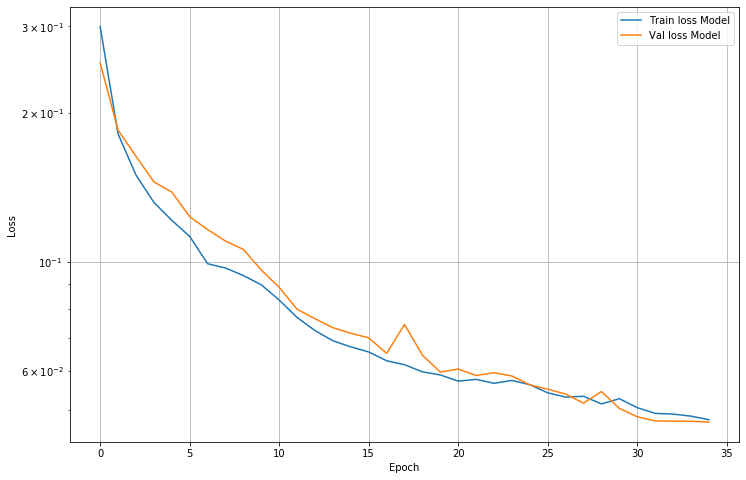

In [31]:
# This cell can be skipped if not interested in the training of the net 
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_losses, label=f'Train loss Model')
plt.semilogy(val_losses, label=f'Val loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [33]:
# Save network parameters
# torch.save(var_encoder.state_dict(), 'var_encoder_params.pth')
# torch.save(var_decoder.state_dict(), 'var_decoder_params.pth')

In [ ]:
## In the case not in interested in training the network, the selected part can be skipped and it can be run ## from here

In [68]:
### Initialize the two networks
encoded_space_dim = 32
input_dim = 128

var_encoder = VarEncoder(input_dim=input_dim, encoded_space_dim=encoded_space_dim)
var_decoder = VarDecoder(output_dim=input_dim, encoded_space_dim=encoded_space_dim)

var_encoder.load_state_dict(torch.load('var_encoder_params.pth'))
var_decoder.load_state_dict(torch.load('var_decoder_params.pth'))

<All keys matched successfully>

In [69]:
# Testing on the test set the denoising autoencoder
var_encoder.to(device)
var_decoder.to(device)

test_loss = test_epoch(
        encoder=var_encoder, 
        decoder=var_decoder, 
        device=device, 
        dataloader=test_dataloader)

# Print Test loss
print('\n\n\t TEST loss: %f\n\n' % test_loss )




	 TEST loss: 0.047585




In [36]:
### Starting the part that actually produces the files to use in COLMAP

In [70]:
def reconstruct_descriptors(encoder, decoder, device, des_batch) :
    encoder.to(device)
    decoder.to(device)

    des_batch = des_batch.to(device)
    # First batch of descriptors to be reconstructed
    with torch.no_grad():
        z, _, _ = encoder(des_batch)
        z = z.to(device)

        # Decode data
        recon_des = decoder(z)

    return recon_des.cpu().numpy()

In [71]:
def filter_matches(matches, ratio) :
    good_matches = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)

    return good_matches

In [72]:
def calculate_matches(des1, des2 , matcher, ratio1, ratio2, encoder, decoder, device) :
    # Matches of full 128 bits descriptors
    matches_orig = matcher.knnMatch(des1, des2, 2)
    matches_orig_refined = filter_matches(matches_orig, ratio1) 

    # Compressing and reconstructing the descriptors
    des1_rec = reconstruct_descriptors(encoder, decoder, device, torch.tensor(des1))
    des2_rec = reconstruct_descriptors(encoder, decoder, device, torch.tensor(des2))

    # Matches of the reconstructed descriptors
    matches_recon = matcher.knnMatch(des1_rec, des2_rec, 2)
    matches_recon_refined = filter_matches(matches_recon, ratio2)

    return matches_orig_refined, matches_recon_refined

In [73]:
# Costant strings
length = ' 128\n'
zeros = ''
for idx in range(128) :
    zeros += '0 ' 

In [74]:
# Function that writes the images feauture information
def kp2colmapformat(path, img_name, keypoints, zeros, length) :
    # Header has the number of feautures and their length
    text = ''
    text += str(len(keypoints)) + length

    for key_point in keypoints :
        pos = str(key_point.pt[0]) + ' ' + str(key_point.pt[1]) + ' '
        info = pos + str(key_point.size) + ' ' + str(key_point.angle)
        text += info + ' ' + zeros + '\n'

    file_des = open(path + img_name + '.txt',"w+")
    file_des.write(text)
    file_des.close()

In [75]:
# Writes the matches between the features of 2 different images
def write_matches(name1, name2, matches) :
    text = name1 + ' ' + name2 + '\n'
    for match in matches :
        text += str(match.queryIdx) + ' ' + str(match.trainIdx) + '\n'
    return text 

In [76]:
# idx_matches represents if we are using the original ones or the reconstructed ones
# It writes the matches files to use on COLMAP
def matches2colmapformat(path, names, matches, idx_matches) :
    text = ''
    counter = 0 
    for idx in range(len(names)) :
        for idy in range(idx + 1, len(names)) :
            text += write_matches(names[idx], names[idy], matches[counter][idx_matches])
            counter += 1
            text += '\n'

    file_des = open(path,"w+")
    file_des.write(text)
    file_des.close()

In [77]:
# Matching using a histogram based matcher
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

In [50]:
#################### Testing #########################

In [81]:
# Insert here the folder in which it is contained the imgs
# it needs to end with a /
folder_test = 'tisoDataset/'
imgs_test_name, imgs_test = get_names_images(folder_test)

In [52]:
# Calculating the matches of both the original descriptors and the reconstructed ones
# It takes a while...
kp_des = [detector.detectAndCompute(img,None) for img in  imgs_test ]
matches_test = []
for idx in range(len(imgs_test)) :
    # Matching of the original features 
    for idy in range(idx + 1, len(imgs_test)) :
        m_or, m_rec = calculate_matches(kp_des[idx][1] , kp_des[idy][1], matcher, 0.75, 0.75, var_encoder,           var_decoder, device)
        matches_test.append((m_or, m_rec))

In [595]:
##### Orgininal descriptors

In [88]:
# Writing images features for the reconstructed descriptors, it can be skipped in the case of desiring only
# the reconstructed descriptors information

# Path in which I want to save the features files of the images for COLMAP
path_or = 'surf_test/feat/'
for idx in range(len(imgs_test_name)) :
    kp2colmapformat(path_or, imgs_test_name[idx], kp_des[idx][0], zeros, length)

In [89]:
# # Path in which I want to save the matching information of the images for COLMAP
path_or = 'surf_test/matches_ori.txt'
matches2colmapformat(path_or, imgs_test_name, matches_test, 0)

In [78]:
####### Reconstructed descriptors

In [93]:
path_rec = 'surf_test/feat_rec/'
for idx in range(len(imgs_test_name)) :
    kp2colmapformat(path_rec, imgs_test_name[idx], kp_des[idx][0], zeros, length)

In [94]:
path_rec = 'surf_test/matches_rec.txt'
matches2colmapformat(path_rec, imgs_test_name, matches_test, 1)